In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

import matplotlib.pyplot as plt

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../../pompjax/pompjax/")
sys.path.insert(0, "../..")
sys.path.insert(0, "../")

from global_config import config

results_dir          = config.get_property('results_dir')
results2_dir         = config.get_property('results2_dir')
data_dir             = config.get_property('data_dir')
paper_dir            = config.get_property('paper_dir')
data_db_dir          = config.get_property('data_db_dir')

data_cluster_dir     = config.get_property('data_cluster_dir')
results_cluster_dir  = config.get_property('results_cluster_dir')

feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")


In [2]:
from utils_local import plot_utils
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
import seaborn as sns

path_to_results = "/Users/chaosdonkey06/Dropbox/shaman-lab/amr-hospitals2/results"
path_to_results = os.path.join(path_to_results, "covid19_sensitivity")


In [3]:

####-####-####-####-####-####-####-####-####-####-####
amro_search  = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
                'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS', 'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS',
                'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

ignore_dates                    = np.arange(2, 16+2, 2)

experiments_df                  = pd.DataFrame(columns=["amro", "dates_ignored"])
experiments_df["dates_ignored"] = list(ignore_dates)*len(amro_search)
experiments_df["amro"]          = flatten_list([[amro]*len(ignore_dates) for amro in amro_search])
experiments_df["scenario"]      = list(np.arange(len(ignore_dates))+1)*len(amro_search)
experiments_df["scenario"]      = experiments_df["scenario"].apply(lambda x: f"scenario{x}")


In [4]:

def empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv"):
    amro_prev_df = pd.read_csv(path_to_prev)
    gammas       = amro_prev_df[amro_prev_df.amro==amro][["prevalence_mean1", "prevalence_mean2", "prevalence_mean3"]].values / 100
    return np.squeeze(gammas)

In [5]:
from utils_local.misc import amro2title, amro2cute

θ_all = np.full((len(amro_search), 8, 3, 2, 300), np.nan)
Nif   = 30

id_run       = 0
posterior_df = pd.DataFrame()

for i_row, row in experiments_df.iterrows():
    amro            = row.amro

    for idx_prev in range(3):
        samples_path    = os.path.join(path_to_results, amro2cute(amro), row.scenario)
        path_to_samples = os.path.join(samples_path, f"prevalence{idx_prev+1}", "000posterior.npz")

        if not os.path.exists(path_to_samples):
            continue

        inference = np.load(path_to_samples)
        θpost     = inference["posterior"]
        Nif       = θpost.shape[-1]

        ρ_post = θpost[0, :, :, :].mean(-2).flatten()
        β_post = θpost[1, :, :, :].mean(-2).flatten()

        amro_index = amro_search.index(row.amro)
        i_date     = np.where(row.dates_ignored==ignore_dates)[0][0]

        θ_all[amro_index, i_date, idx_prev, 0, :] = θpost[0, :, :, :].mean(-2)[:, -1] * 100
        θ_all[amro_index, i_date, idx_prev, 1, :] = θpost[1, :, :, :].mean(-2)[:, -1]

        gammas = empirical_prevalence(amro, path_to_prev="../../data/amro_prevalence.csv")

        post_df                  = pd.DataFrame(columns=["value", "param", "ens_id", "if_iter"])
        post_df["value"]         = np.concatenate([ρ_post, β_post])
        post_df["param"]         = ["ρ"] * len(ρ_post) + ["β"] * len(β_post)
        post_df["if_iter"]       = flatten_list([list(range(Nif)) * 300  ] * 2 )
        post_df["ens_id"]        = flatten_list([[i] * Nif for i in range( 300 )] * 2)
        post_df["gamma"]         = gammas[idx_prev]
        post_df["skipped_dates"] = row.dates_ignored
        post_df["amro"]          = row.amro
        posterior_df             = pd.concat([posterior_df, post_df])

v_df = posterior_df[posterior_df["if_iter"] == Nif-1]


In [11]:
θ_all.shape

(7, 8, 3, 2, 300)

In [16]:
ignore_dates

array([ 2,  4,  6,  8, 10, 12, 14, 16])

Text(0.01, 0.5, 'weeks ignored')

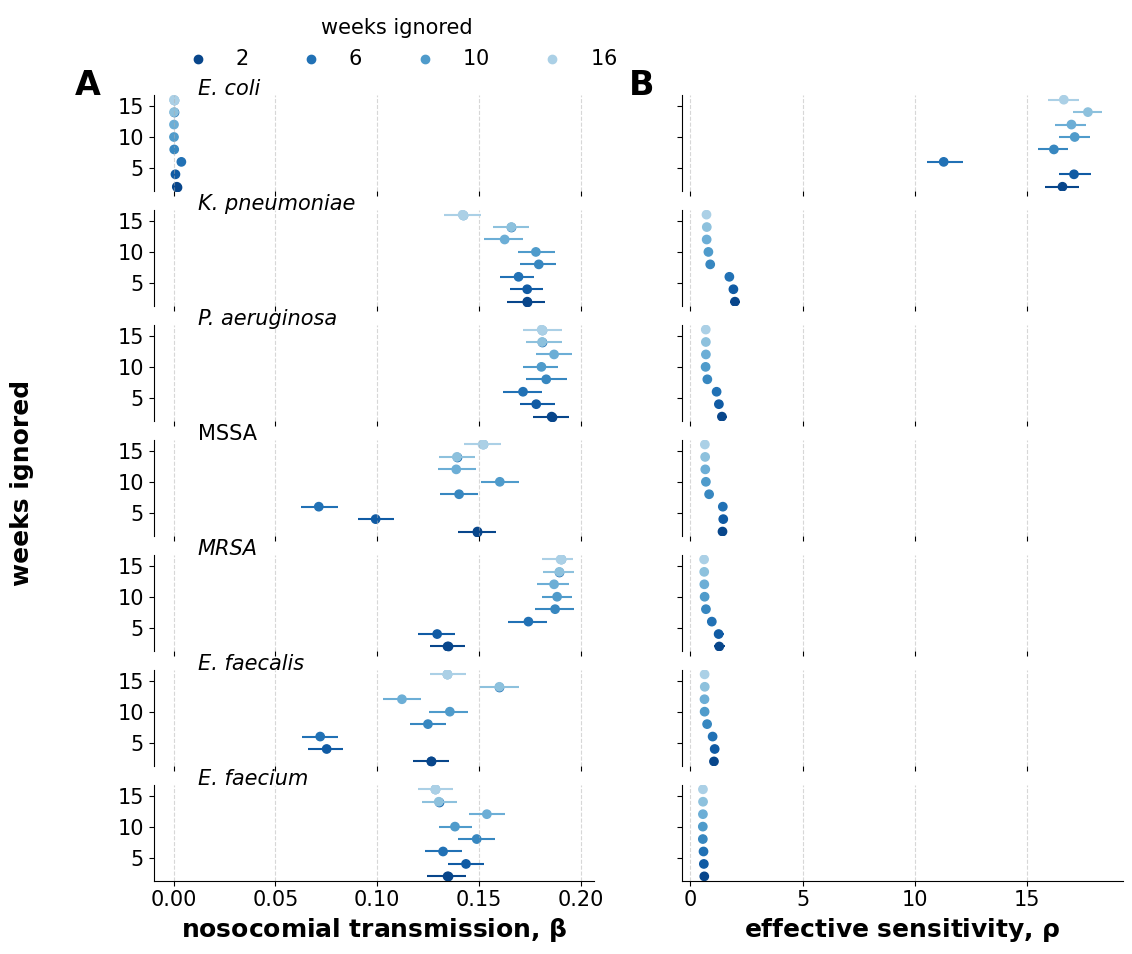

In [27]:
from utils_local.misc import amro2title, amro2cute
COLORS_GAMMA = sns.color_palette("Blues_r", len(ignore_dates)+3)[:-3]

fig, ax = plt.subplots(len(amro_search), 2, figsize=(12.5, 10.2), sharey="row", sharex="col")


prev_idx = 0
θ_mean   = θ_all[:, :, prev_idx, :, :].mean(-1)

for i_amro, amro in enumerate(amro_search):

    y_axis = ignore_dates

    ### for ro
    quant = np.quantile(θ_all[i_amro, :, prev_idx, 0, :], q=[0.05, 0.95], axis=1)

    ax[i_amro, 1].hlines(y   = y_axis,
                        xmin = quant[1, :],
                        xmax = quant[0, :], color=COLORS_GAMMA)

    ax[i_amro, 1].scatter(θ_mean[i_amro, :, 0], y_axis, fc=COLORS_GAMMA, ec=None)

    ax[i_amro, 0].scatter(θ_mean[i_amro, :, 1][[0]], y_axis[[0]],   fc=COLORS_GAMMA[0],  label=r"${}$".format(ignore_dates[0]))
    ax[i_amro, 0].scatter(θ_mean[i_amro, :, 1][[6]], y_axis[[6]],   fc=COLORS_GAMMA[2],  label=r"${}$".format(ignore_dates[2]))
    ax[i_amro, 0].scatter(θ_mean[i_amro, :, 1][[-1]], y_axis[[-1]], fc=COLORS_GAMMA[4], label=r"${}$".format(ignore_dates[4]))
    ax[i_amro, 0].scatter(θ_mean[i_amro, :, 1][[-1]], y_axis[[-1]], fc=COLORS_GAMMA[-1], label=r"${}$".format(ignore_dates[-1]))

    ### for β ###
    quant = np.quantile(θ_all[i_amro, :, prev_idx, 1, :], q=[0.05, 0.95], axis=1)

    ax[i_amro, 0].hlines(y   = y_axis,
                        xmin = quant[1, :],
                        xmax = quant[0, :], color=COLORS_GAMMA)
    ax[i_amro, 0].scatter(θ_mean[i_amro, :, 1], y_axis, fc=COLORS_GAMMA, ec=None)

    #ax[i_amro, 0].axhline(y=gamma[0]*100, color="green", linestyle="--", lw=0.5)
    #ax[i_amro, 0].axhline(y=gamma[1]*100, color="green", linestyle="--", lw=0.5)
    #ax[i_amro, 1].axhline(y=gamma[0]*100, color="green", linestyle="--", lw=0.5)
    #ax[i_amro, 1].axhline(y=gamma[1]*100, color="green", linestyle="--", lw=0.5)

#ax[0, 0].set_ylim((18, 80))

for axi in ax.flatten():
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

    axi.grid(axis="x", linestyle="--", alpha=0.5)

for i_amro in range(len(amro_search)-1):
    ax[i_amro, 0].spines["bottom"].set_visible(False)
    ax[i_amro, 1].spines["bottom"].set_visible(False)

for i_amro in range(len(amro_search)):
    if amro2title(amro_search[i_amro])!="MSSA":
        style = "italic"
    else:
        style = "normal"
    ax[i_amro, 0].text(s         = amro2title(amro_search[i_amro]),
                       x         = 0.1,
                       y         = 1.0,
                       transform = ax[i_amro, 0].transAxes,
                       style     = style)

ax[0, 0].text(s       = "A",
            x         = -0.18,
            y         = 1.0,
            transform = ax[0, 0].transAxes,
            weight    = "bold",
            fontsize  = 24)
ax[0, 1].text(s       = "B",
            x         = -0.12,
            y         = 1.0,
            transform = ax[0, 1].transAxes,
            weight    = "bold",
            fontsize  = 24)

ax[0, 0].legend(title          = r"weeks ignored",
                bbox_to_anchor = (0.01, 2.0),
                loc            = 'upper left',
                ncol           = 4,
                frameon        = False)

ax[-1, 0].set_xlabel(r"nosocomial transmission, $\mathbf{\beta}$", weight="bold")
ax[-1, 1].set_xlabel(r"effective sensitivity, $\mathbf{\rho}$", weight="bold")

fig.supylabel("weeks ignored", x=0.01, weight="bold")
#fig.savefig(os.path.join("figures", "gamma_sensitivity.png"), dpi=300, transparent=True, bbox_inches = 'tight')


In [25]:
ignore_dates

array([ 2,  4,  6,  8, 10, 12, 14, 16])

In [24]:
len(ignore_dates)

8

In [29]:
path_to_save = os.path.join(results2_dir, "amro_inferences", "abm", f"{amro2cute(amro)}")
os.listdir(path_to_save)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/chaosdonkey06/Dropbox/shaman-lab/amr-hospitals/results2/amro_inferences/abm/e_faecium'